## Intorduction

Covid-19 has a significant impact on people's lives in all countries all over the world. Social media plays an especially important role in the global efforts to contain the pandemic as it allows us to communicate vital information to the general public in a fast and reliable way. However, the influence of such communication on the spread of the virus varies from communicator to communicator. In this research, we analyze the effectiveness of conveying covid-19 information to the Canadian public of 3 Canadian government tweeter accounts, namely, the Public Health Agency of Canada, the Chief Public Health Officer of Canada and the Prime Minister of Canada. The effectiveness is measured as the number of new Covid-19 cases after the publication of a tweet. 

Below is the outline of the content of the notebook:
1. **Datasets** - creating datasets for ML models
  1. **Daily Covid-19 data** - getting and understanding daily Covid-19 data
  2. **Twitter data** - getting and preprocessing twitter data
  3. **Dataset building** - labling the twitter data to build two datasets
2. **Model A building** - building a model on the first dataset
3. **Model B building** - building a model on the second dataset
4. **Models comparison** - models comparison and final recomendations

## Datasets

In this section we will fetch daily Covid-19 and twitter data, label the tweets and build two version of dataset. The first version will be based on the assumption that today's tweet will get a label using the next day number of new cases. The second version will be based on the assumption that today's tweet will get a label using the number of new cases in 14 days.

The label is a categorical variable that has three values:
* $+1$ - Increase the spread of COVID19
*  $0$ - No change on the spread of COVID19
* $-1$ - Decrease the spread of COVID19

### Daily Covid-19 data

To get the daily covid-19 cases in Canada we load the [Open COVID-19 datset](https://github.com/GoogleCloudPlatform/covid-19-open-data) that is also available via Google BigQuery.

In [1]:
import pandas as pd

# Load CSV data directly from the URL with pandas
covid_data_df = pd.read_csv(
    "https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv")

In [2]:
# select canada data
covid_data_ca_df = covid_data_df[covid_data_df.key == 'CA']
# covert the date string to a datetime object
covid_data_ca_df['date'] = pd.to_datetime(covid_data_ca_df['date'])
# set data as an index in the dataframe
covid_data_ca_df.set_index('date', inplace=True)

# output the dataframe info
covid_data_ca_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2019-12-30 to 2020-10-17
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              293 non-null    object 
 1   new_confirmed    293 non-null    float64
 2   new_deceased     293 non-null    float64
 3   new_recovered    205 non-null    float64
 4   new_tested       220 non-null    float64
 5   total_confirmed  293 non-null    float64
 6   total_deceased   293 non-null    float64
 7   total_recovered  193 non-null    float64
 8   total_tested     221 non-null    float64
dtypes: float64(8), object(1)
memory usage: 22.9+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [3]:
# remove the country key from the dataframe
covid_data_ca_df.drop('key',axis=1,inplace=True)
covid_data_ca_df

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested
date,,,,,,,,
2019-12-30,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2019-12-31,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-01,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-02,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
2020-01-03,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-10-13,4042.0,27.0,3228.0,78084.0,186881.0,9654.0,157486.0,8269676.0
2020-10-14,2506.0,10.0,1865.0,83393.0,189385.0,9664.0,159351.0,8353069.0
2020-10-15,2345.0,35.0,2139.0,50075.0,191730.0,9699.0,161490.0,8403144.0


Understanding summary statistics of the covid-19 data:

In [4]:
covid_data_ca_df.describe()

,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested
count,293.000000,293.000000,205.000000,220.000000,293.000000,293.000000,193.000000,2.210000e+02
mean,670.037543,33.262799,805.931707,39242.027273,70680.286689,4934.686007,79567.740933,3.182132e+06
std,687.218253,51.578068,1763.689414,22421.745346,59057.023906,4110.379460,43329.572495,2.493074e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,230.000000,1.102300e+04
25%,20.000000,0.000000,329.000000,23236.250000,138.000000,2.000000,45352.000000,9.426020e+05
50%,413.000000,7.000000,575.000000,37647.500000,84688.000000,6424.000000,71841.000000,2.721685e+06
75%,1133.000000,44.000000,896.000000,49360.250000,118172.000000,8962.000000,113664.000000,5.115490e+06
max,4042.000000,222.000000,23853.000000,159915.000000,196321.000000,9746.000000,165446.000000,8.644269e+06


From the plot below we can see that the number of new cases has two peaks: from March to April and from September to October. Also, the number of testing is growing all the times.

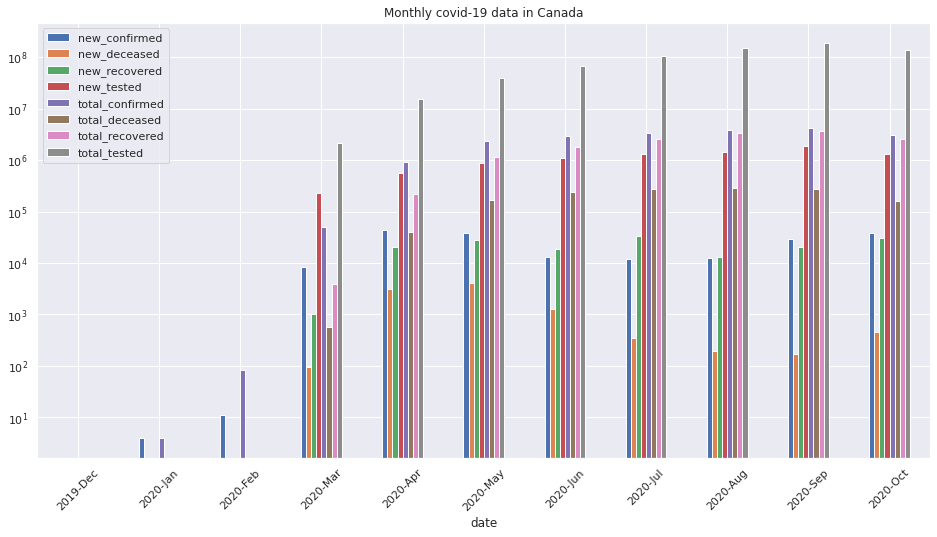

In [5]:
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(16,8)})

title = "Monthly covid-19 data in Canada"
covid_monthly_df=covid_data_ca_df.resample('M').sum()
covid_monthly_df.index = covid_monthly_df.index.strftime('%Y-%b')
covid_monthly_df.plot(kind='bar',logy=True, rot=45, title=title);

Here we plot the dayly confirmed cases as well as 7, 14, 30 days moving average to see the overall trend. The graph is consistent with the conclusion that there are two waves in the pandemic.

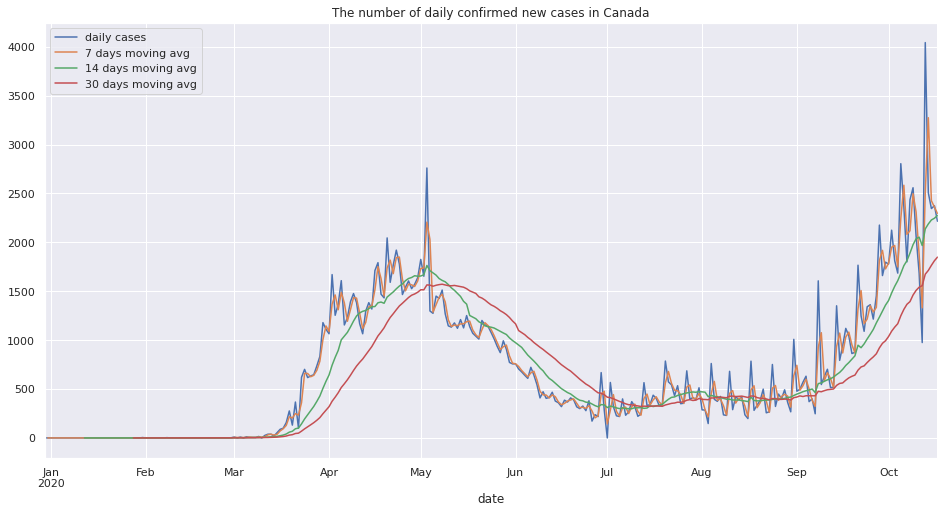

In [6]:
# plot the number of daily confirmed new cases as a line plot
title = "The number of daily confirmed new cases in Canada"

ax = covid_data_ca_df['new_confirmed'].plot(kind='line', title=title, label='daily cases');
# 7 days moving average
covid_data_ca_df['new_confirmed'].rolling(window=2).mean().plot(kind='line',ax=ax, label='7 days moving avg');
# 14 days moving average
covid_data_ca_df['new_confirmed'].rolling(window=14).mean().plot(kind='line',ax=ax, label='14 days moving avg');
# 30 days moving average
covid_data_ca_df['new_confirmed'].rolling(window=30).mean().plot(kind='line',ax=ax, label='30 days moving avg');
ax.legend();

### Twitter data

In this section we collect twitter data relate to three Government of Canada accounts in the period from November 1, 2019 to October 1, 2020:

* The Public Health Agency of Canada ([@GovCanHealth](https://twitter.com/govcanhealth))
* The Chief Public Health Officer of Canada ([@CPHO_Canada](https://twitter.com/CPHO_Canada))
* The Prime Minister of Canada ([@JustinTrudeau](https://twitter.com/JustinTrudeau))

To collect the tweets we used a comand line [scraping tool](https://github.com/JustAnotherArchivist/snscrape/tree/master/snscrape) that provides us with a JSON file with the tweets and relevant information.

In [7]:
TWEETER_DATA_FILE = 'TwitterData.json'
tweets_json_df = pd.read_json(TWEETER_DATA_FILE, lines=True)
tweets_json_df.sample(2)

,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,likeCount,quoteCount,conversationId,lang,source,media,retweetedTweet,quotedTweet,mentionedUsers
8291,https://twitter.com/JustinTrudeau/status/12302...,2020-02-19 22:45:17+00:00,Investing in housing changes peoples’ lives – ...,Investing in housing changes peoples’ lives – ...,1230262103673626624,"{'username': 'JustinTrudeau', 'displayname': '...","[https://bit.ly/39OMUxT, https://twitter.com/H...","[https://t.co/O65LkMQiGn, https://t.co/liiTDMK...",211,98,560,26,1230262103673626624,en,"<a href=""http://twitter.com/download/iphone"" r...",None,NaN,{'url': 'https://twitter.com/HonAhmedHussen/st...,"[{'username': 'HonAhmedHussen', 'displayname':..."
1647,https://twitter.com/GovCanHealth/status/124538...,2020-04-01 16:28:17+00:00,Use the Government of Canada COVID-19 app to g...,Use the Government of Canada COVID-19 app to g...,1245387519153377285,"{'username': 'GovCanHealth', 'displayname': 'H...",[https://ca.thrive.health/],[https://t.co/toL1iW3B1V],23,519,465,40,1245387519153377285,en,"<a href=""https://www.hootsuite.com"" rel=""nofol...",[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,None


In [8]:
# check for NaN values
tweets_json_df['content'].isnull().values.any()

False

In [9]:
# check the number of empty tweets
len(tweets_json_df[tweets_json_df['content'] == ''])

0

Here we select the relevant tweeter data that we will use to build our dataset:

In [10]:
twitter_data_df = pd.DataFrame()
twitter_data_df['tweet_id'] = tweets_json_df['id']
twitter_data_df['screen_name'] = pd.DataFrame.from_records(tweets_json_df['user'])['displayname']
twitter_data_df['created_at'] = tweets_json_df['date'].apply(lambda x: x.tz_localize(None).round('D'))
twitter_data_df['text'] = tweets_json_df['content']
twitter_data_df

,tweet_id,screen_name,created_at,text
0,1311440757639778304,Health Canada and PHAC,2020-10-01,Join the 3 million Canadians already using #CO...
1,1311425668614414336,Health Canada and PHAC,2020-10-01,"New data: 1,067 hospitalizations related to #o..."
2,1311418088995291145,Health Canada and PHAC,2020-10-01,#ADVISORY : Allergan Inc. withdraws its drug #...
3,1311410580931084295,Health Canada and PHAC,2020-10-01,"It’s #BackToSchool season, and that means #flu..."
4,1311399188723363841,Health Canada and PHAC,2020-10-01,Good job Canada. 🇨🇦 The #COVIDAlert exposure n...
...,...,...,...,...
8985,1191181429759234049,Justin Trudeau,2019-11-04,@NLWildlife @Marner93 @91Tavares @MapleLeafs H...
8986,1190390048413368320,Justin Trudeau,2019-11-02,Our thoughts are with everyone affected by the...
8987,1190389980201443329,Justin Trudeau,2019-11-02,Nos pensées accompagnent toutes les personnes ...
8988,1190333824267407363,Justin Trudeau,2019-11-02,¡Gracias @lopezobrador_! We’ve made progress t...


Let's explore the twitter data. We can see that the Public Health Oficer of Canada tweets the most in the given time frame. While the Health Canada and the Prime Minister tweet about the same.

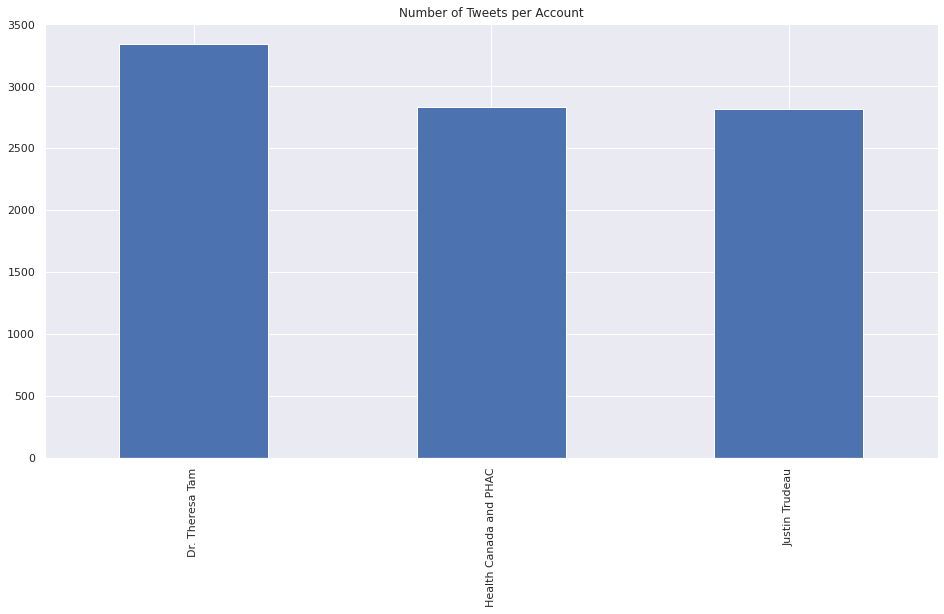

In [11]:
# the amount of tweets for each account
import matplotlib.pyplot as plt
plt.title('Number of Tweets per Account')
twitter_data_df['screen_name'].value_counts().plot.bar();

Let's count the number of tweets per day for each account and compare the dynamics between accounts. From the boxplot we can see that the Public Health Officer tweets the highest number of tweets per day while the Health Canada tweets the least number of tweets. However, the mean number of tweets per day is not significantly different betweet the three accounts.

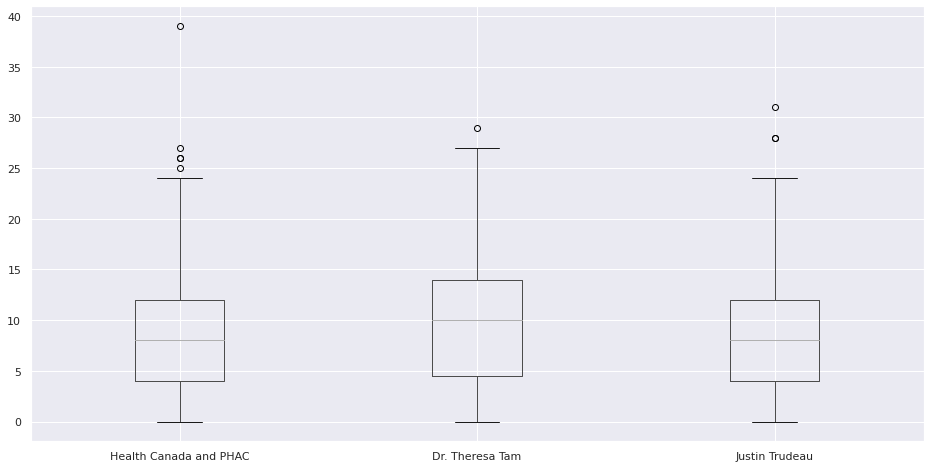

In [12]:
def get_daily_freq(df):
  # covert the date string to a datetime object
  df.loc[:,'created_at'] = pd.to_datetime(df['created_at'])
  # set data as an index in the dataframe
  df.set_index('created_at', inplace=True)
  return df.resample('d').count()['screen_name']

accounts = twitter_data_df['screen_name'].unique()

freq_df = pd.concat([
get_daily_freq(twitter_data_df[twitter_data_df['screen_name'] == accounts[0]].copy()),
get_daily_freq(twitter_data_df[twitter_data_df['screen_name'] == accounts[1]].copy()),
get_daily_freq(twitter_data_df[twitter_data_df['screen_name'] == accounts[2]].copy())], axis=1)

freq_df.columns = accounts

freq_df.boxplot();

Let's clean the tweets to remove irrelevant text.
We will start by detecting and removing non-english text from the dataframe.


In [13]:
%%capture 
!pip install langdetect
from langdetect import detect

In [14]:
# detect language of a tweet
lang_list = []
for row in twitter_data_df['text'].to_list():
    try:
        lang_list += [detect(row)]
    except:
        lang_list += ["error"]
        
twitter_data_df['lang'] = lang_list

As we can see from the bar graph the two health agencies mostly tweet in english whereas the Prime Menister tweets in english and french equally.

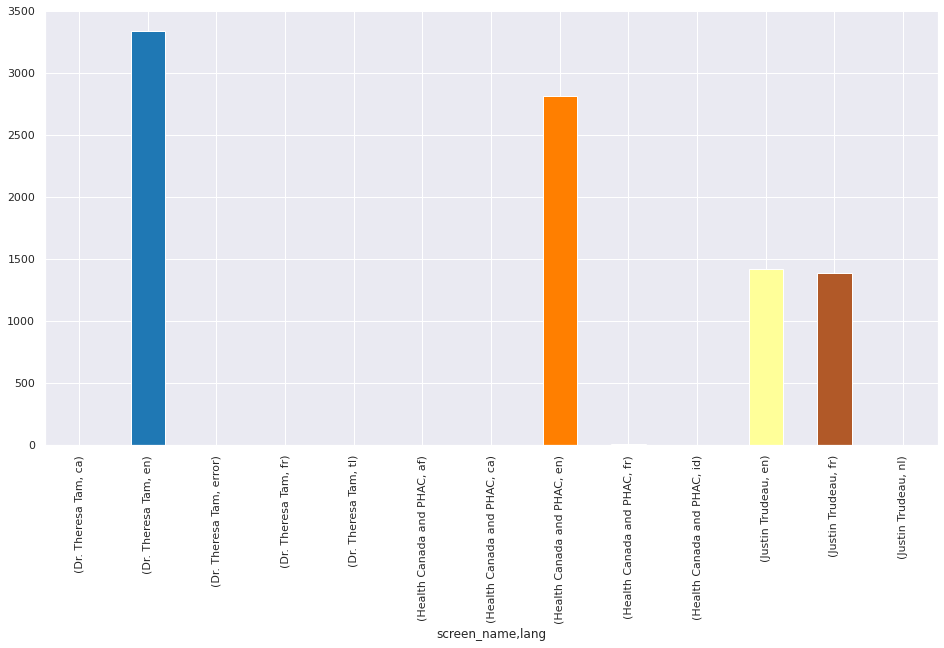

In [15]:
import numpy as np
lang_groups = twitter_data_df.groupby(['screen_name', 'lang'], group_keys =True).size()
lang_groups.plot(kind="bar", color=plt.cm.Paired(np.arange(lang_groups.shape[0])));

In [16]:
# remove non-english tweets
non_eng_df = twitter_data_df[twitter_data_df['lang'] != 'en']
twitter_data_df = twitter_data_df.drop(non_eng_df.index).reset_index(drop=True)

# remove the language column
twitter_data_df.drop('lang', axis=1, inplace=True, errors='ignore')

Let's take a look at random example of tweets in our dataset. We can see that there is a lot of information present. Hashtags, urls, mentions etc.

In [17]:
print('Examples of tweets: \n')
with pd.option_context('display.max_colwidth', -1):
  print(twitter_data_df.sample(5)['text'])

Examples of tweets: 

3864    5/8 Also, people without symptoms may be infected with the virus. If you think you have been exposed to the virus, stay home and contact local #publichealth for advice on next steps, including when and how to seek testing.                                                    
2369    #Vaping products can contain nicotine. Nicotine is known to alter teen brain development and can affect memory and concentration. Youth are particularly vulnerable to the health effects of nicotine.\nLearn more: https://t.co/yIs1qM2SNq https://t.co/loIqSIteM4               
6458    For the past few months, @cafreeland and I have been holding weekly calls with the premiers to make sure we’re moving forward together. Tonight was our 15th call, and we spoke about the safe restart of our economy and making sure everyone has the support they need.         
2572    Shovelling the snow ❄️  can be a great way to #getactive! Make sure your little helpers are dressed warmly and before you

Here we will explore hashtags in the text as it may help us to identify whether a tweet is related to Covid-19. Let's start with counting all the hashtags:

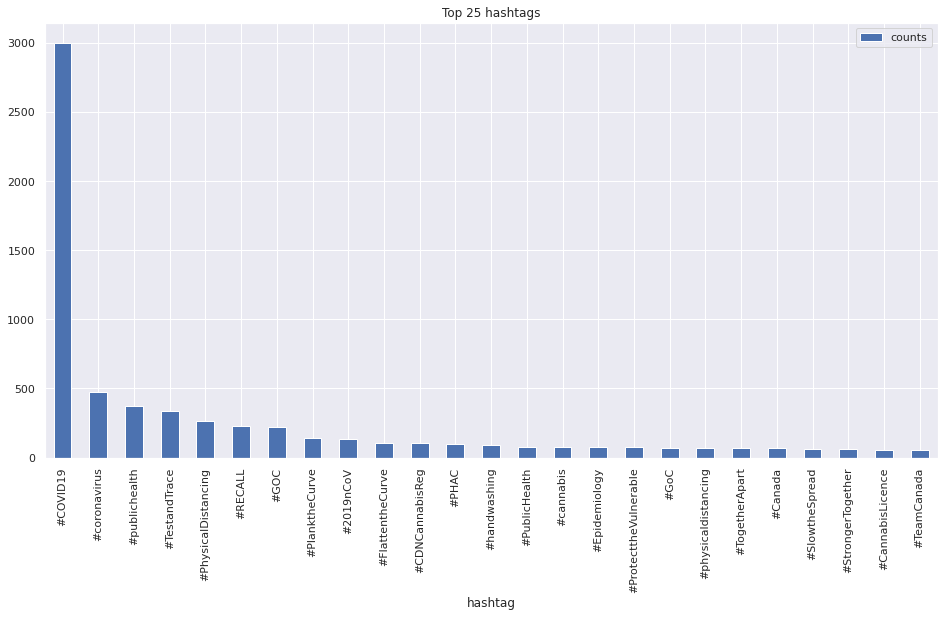

In [18]:
import re

# count all hashtags
HASHTAG_PATTERN = re.compile(r'(?P<hashtag>#\w*)')
hashtag_counts_df = twitter_data_df['text'].str.extractall(HASHTAG_PATTERN).value_counts()
hashtag_counts_df = pd.DataFrame(hashtag_counts_df.values, hashtag_counts_df.index.get_level_values(0),['counts'])

k = 25
# TODO: desplay each tag as a distribution of values between the three accounts
hashtag_counts_df[:k].plot.bar(title=f'Top {k} hashtags');

As we can see from the above graph the #covid19 hashtag accounts for the majority of all hashtags. Therefore, we can conclude that there is a lot of covid19 related information in the tweets. Additionally, we can see that the accounts try to inform the public about specific measures that may prevents the spread of the virus such as physical distancing, handwashing and staying at home if sick.

At the same time there are some irrelevant to covid-19 hashtags (#GOC, #recall etc) that may by an indicator that there is no virus ralated information in the tweets.

### Dataset building

Here we will build two datasets. 

The first dataset will be based on the assumption that today's tweet will get a label using the number of new cases intomorrow day. The second dataset will be based on the assumption that a tweet published today will get a label using the number of new cases in 14 days after the tweet is posted.

We will use following encodings for the labels:

* $+1$ - Increase the spread of COVID19
*  $0$ - No change on the spread of COVID19
* $-1$ - Decrease the spread of COVID19


To encode the tweets we will use contextual word embeddings from the BERT language model which was finetuned on covid-19 related twitter data.

Let's clean the tweets according to the data that the BERT covid-19 model was trained on. For this we will use the preprocessing script from the [COVID-Twitter-BERT](https://github.com/digitalepidemiologylab/covid-twitter-bert) repository:

In [19]:
%%capture
!rm -rf covid-twitter-bert/
!git clone https://github.com/digitalepidemiologylab/covid-twitter-bert.git
!pip install -r covid-twitter-bert/requirements.txt
!pip install -q tf-models-official==2.3.0

In [20]:
# In order to use the preprocessing twitter script we need to
# creat a tsv file with the tweets and mock lables
dataset_df = pd.DataFrame({
    'text'  : twitter_data_df['text'],
    'label' : [0]*len(twitter_data_df)
})

dataset_df.index.name = 'id'

# save tweets to tsv
dataset_df.to_csv('dataset.tsv',sep='\t')

Cleaning the tweets:

In [21]:
# here we preprocess the twitter data according to the bert model
# The preprocessing will replace usernames and urls with <twitteruser> and <twitterurl>
# with some additional tranformation such making all word lower case
%%capture
%cd covid-twitter-bert/preprocess/
!python create_predict_data.py --input_txt_file ../../dataset.tsv
%cd ../../

Read preprocessed clean tweets:

In [22]:
import glob
import os

list_of_files = glob.glob('covid-twitter-bert/data/predict_data/*/preprocessed/')
latest_file = max(list_of_files, key=os.path.getctime)

# read the file with clean tweets
file_content = open(latest_file + 'dataset.tsv', 'r').read()

# remove header
file_content = file_content.replace("id text label\n","",1)
# split file by delimiter
clean_tweets_list = re.split(' 0\n(?=\d+)', file_content)
# remove index
clean_tweets_list = [re.sub('\d+ ', '', tweet) for tweet in clean_tweets_list]
# add to the dataframe
twitter_data_df['clean_text'] = clean_tweets_list

Now we are ready to get BERT embeddings. We will use the feature extraction pipeline from the transformers library. The feature extraction pipeline will return a word embedding for every token in the input. To get a tweet embedding we will remove the first and last word embeddings that corespond to the [CLS] and [SEP] tokens and average all the remaining embeddings.

In [23]:
%%capture
!pip install transformers

In [24]:
from transformers import pipeline
import numpy as np
import tqdm

# Create the feature extraction pipeline with the COVID-19 twitter BERT model.
# Also, by specifing the device id we enable the use of GPU
model_name = 'digitalepidemiologylab/covid-twitter-bert-v2'
pipe = pipeline(task='feature-extraction', model=model_name, framework='pt',device=0)

tweet_embeddings = []
for tweet in tqdm.notebook.tqdm(clean_tweets_list):
    embeddings = np.array(pipe(tweet)).squeeze(0)
    tweet_embeddings += [embeddings[1:-1,:].mean(axis=0)]

We will use KMeans to find proper boundaries for the number of COVID-19 cases to assign a label.

In [25]:
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(3,  distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(tweet_embeddings, assign_clusters=True)
twitter_data_df['cluster'] = assigned_clusters

Here we extract the change in daily cases for two assumptions. The first assumption is today tweet will have the value of tomorrow new cases. The second assumption is today tweet will have the value of new cases in 14 days.

In [26]:
# get number of new cases with an offset in days
def get_num_of_cases(offset_days = 0):
    records = []
    for t in twitter_data_df.created_at+pd.DateOffset(days=offset_days):
        if t in covid_data_ca_df.index:
            records += [covid_data_ca_df.loc[[t]]['new_confirmed'].values[0]]
        else:
            records += [0]
    return records

We will generate the difference in the new cases from in 1 day and in 14 day
we will use this information during the lable assignment.

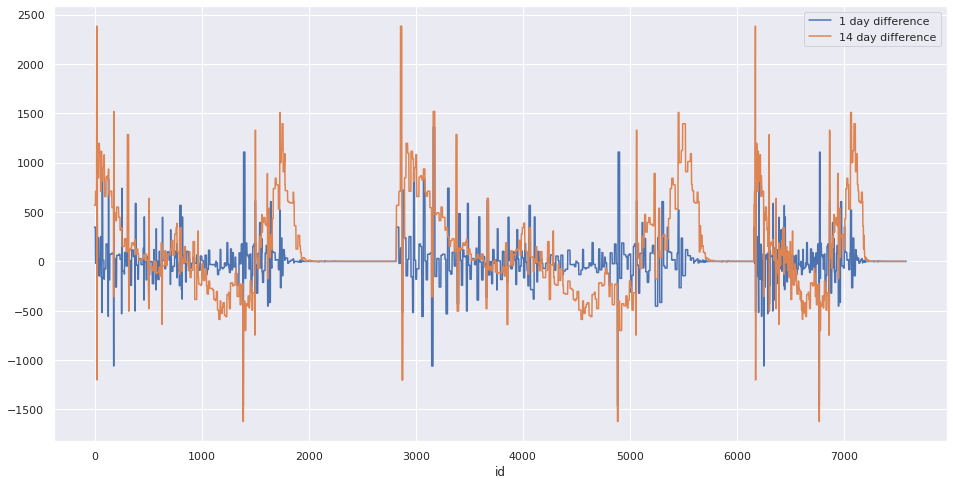

In [27]:
today_cases = get_num_of_cases(offset_days=0)
one_day_cases = get_num_of_cases(offset_days=1)
forteen_day_cases = get_num_of_cases(offset_days=14)

twitter_data_df['1_day_new_cases'] = [val_2 - val_1 for (val_1, val_2) in zip(today_cases, one_day_cases)]
twitter_data_df['14_days_new_cases'] = [val_2 - val_1 for (val_1, val_2) in zip(today_cases, forteen_day_cases)]

# plot the difference in new cases
ax = twitter_data_df['1_day_new_cases'].plot(kind="line", label='1 day difference')
ax = twitter_data_df['14_days_new_cases'].plot(kind="line",label='14 day difference',ax=ax)
ax.legend();

Let's explore the boundaries of the number of new cases in each cluster to assign lables:

In [28]:
# meand and standard deviation for each of the clusters
group = twitter_data_df.drop('tweet_id',axis=1).groupby('cluster')
group.mean().round(2).astype(str) +" (+/-"+ group.std().round(2).astype(str) +")"

,1_day_new_cases,14_days_new_cases
cluster,,
0,11.81 (+/-242.46),128.32 (+/-453.34)
1,6.61 (+/-204.82),94.83 (+/-457.53)
2,8.98 (+/-195.59),120.53 (+/-412.39)


In [29]:
# boundaries of new cases for each of the clusters
left_boundaries = group.mean() - group.std()
right_boundaries = group.mean() + group.std()
left_boundaries.round(2).astype(str) + ' : ' + right_boundaries.round(2).astype(str)

,1_day_new_cases,14_days_new_cases
cluster,,
0,-230.65 : 254.28,-325.02 : 581.66
1,-198.22 : 211.43,-362.7 : 552.37
2,-186.61 : 204.56,-291.86 : 532.93


As we can see there is a lot of variation in the number of new cases in the clusters. Also, there is a significant overlap between the boundaries. This is probably because the tweets don't correlate much with the number of new cases which means the impact of a tweet is very small. 

Let's use a simple heuristics instead. We will assign 'no change' if the number of new cases falls within the boundaries of the cluster with the shortest interval. If the value of new cases is bigger than that interval we will assign "increase in cases" and "decrease in cases" otherwise.

In [30]:
shortest_1_day_interval = [left_boundaries.max()['1_day_new_cases'], right_boundaries.min()['1_day_new_cases']]
shortest_14_day_interval = [left_boundaries.max()['14_days_new_cases'], right_boundaries.min()['14_days_new_cases']]

In [31]:
def get_label(x, interval):
    if x > interval[0] and x < interval[1]:
        return 0 # no change
    elif x < interval[0]:
        return -1 # decrease
    else:
        return 1 # increase

twitter_data_df['1_day_label'] = twitter_data_df['1_day_new_cases'].apply(lambda x: get_label(x, shortest_1_day_interval))
twitter_data_df['14_day_label'] = twitter_data_df['14_days_new_cases'].apply(lambda x: get_label(x, shortest_14_day_interval))

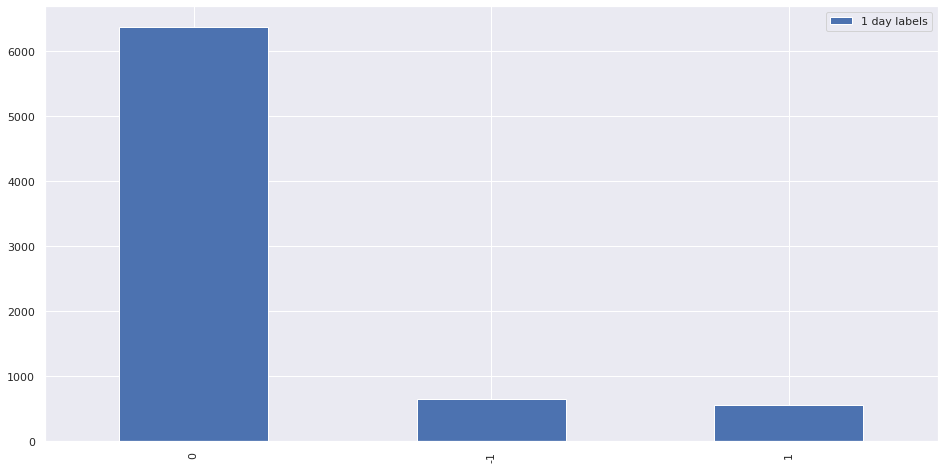

In [32]:
# let's plot the discribution of cases for 1 day
ax = twitter_data_df['1_day_label'].value_counts().plot.bar(label='1 day labels')
ax.legend();

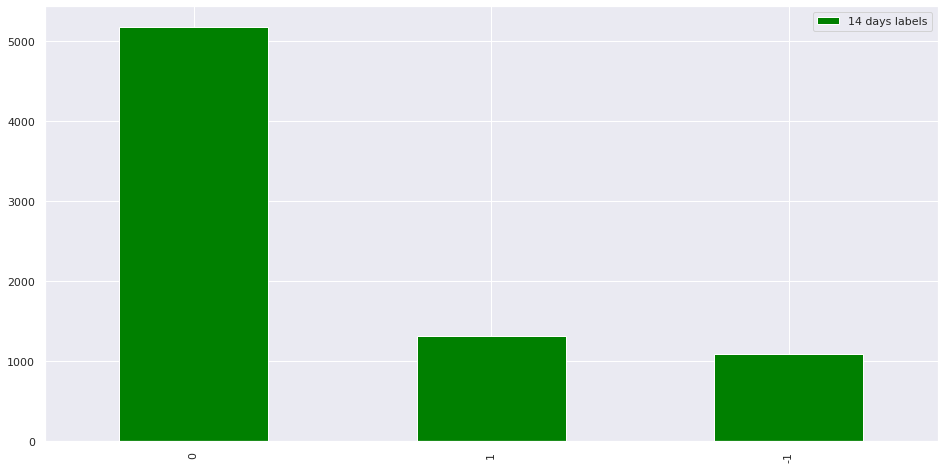

In [33]:
# let's plot the discribution of cases for 14 day
ax = twitter_data_df['14_day_label'].value_counts().plot.bar(label='14 days labels',color='green')
ax.legend();

Additionaly, we will visualize embeddings to see if they form any clasters. Here we are using t-SNE to project the tweet embedding on to a plane.

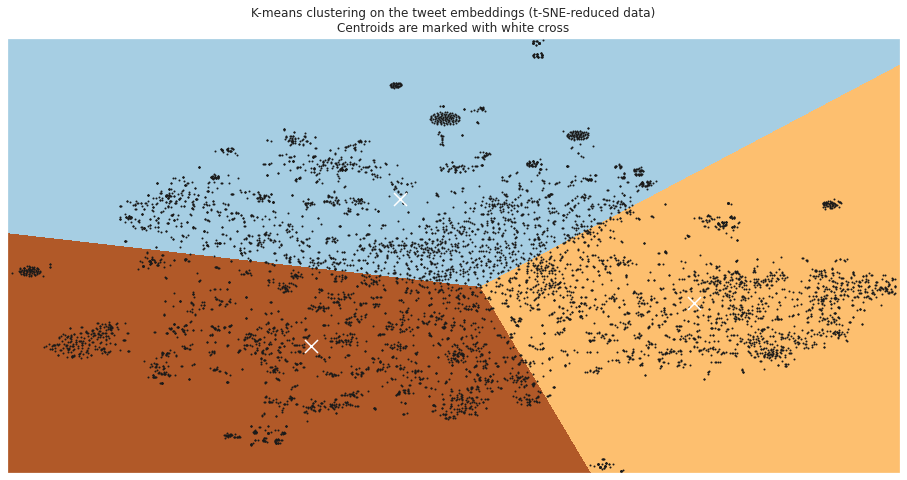

In [36]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

reduced_data = TSNE(n_components=2,perplexity=45,n_iter=1500).fit_transform(tweet_embeddings)
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the tweet embeddings (t-SNE-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Model A building

We will use a random forest as a model because it has a good trade-off between bias and variance and also efficient for big data.

Additionaly, we will split the datasets on training, validation and testing splits.

In [37]:
train_df = twitter_data_df[twitter_data_df['created_at'] < '2020-04-01']
val_df = twitter_data_df[(twitter_data_df['created_at'] > '2020-04-01') & (twitter_data_df['created_at'] < '2020-09-01')]
test_df = twitter_data_df[twitter_data_df['created_at'] > '2020-09-01']

In [38]:
X_train = np.array(tweet_embeddings)[train_df.index.to_list()]
y_train = train_df['1_day_label'].to_numpy()

X_val = np.array(tweet_embeddings)[val_df.index.to_list()]
y_val = val_df['1_day_label'].to_numpy()

X_test = np.array(tweet_embeddings)[test_df.index.to_list()]
y_test = test_df['1_day_label'].to_numpy()

Here we will tune hyperparameters. Specifically, we will find the best value for the number of trees in the forest by culculation the micro F1 average on validation set:

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

num_of_trees_values = [2, 4, 8, 16, 32, 64]

for value in num_of_trees_values:
    clf = RandomForestClassifier(n_estimators=value).fit(X=X_train, y=y_train)
    y_pred = clf.predict(X=X_val)
    print(f"{value}: {f1_score(y_val, y_pred, average='micro')}")

2: 0.7569750367107196
4: 0.7958883994126283
8: 0.8073910915320606
16: 0.8098384728340675
32: 0.8098384728340675
64: 0.8098384728340675


Testing the model with the best hyperparameters

In [40]:
clf = RandomForestClassifier(n_estimators=16).fit(X=X_train, y=y_train)
y_pred = clf.predict(X=X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       123
           0       0.64      1.00      0.78       525
           1       0.00      0.00      0.00       166

    accuracy                           0.64       814
   macro avg       0.21      0.33      0.26       814
weighted avg       0.42      0.64      0.51       814



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model B building

Here we build the second model on the number of new cases in 14 days:

In [41]:
X_train = np.array(tweet_embeddings)[train_df.index.to_list()]
y_train = train_df['14_day_label'].to_numpy()

X_val = np.array(tweet_embeddings)[val_df.index.to_list()]
y_val = val_df['14_day_label'].to_numpy()

X_test = np.array(tweet_embeddings)[test_df.index.to_list()]
y_test = test_df['14_day_label'].to_numpy()

In [42]:
num_of_trees_values = [2, 4, 8, 16, 32, 64]

for value in num_of_trees_values:
    clf = RandomForestClassifier(n_estimators=value).fit(X=X_train, y=y_train)
    y_pred = clf.predict(X=X_val)
    print(f"{value}: {f1_score(y_val, y_pred, average='micro')}")

2: 0.6431718061674009
4: 0.6223690651003426
8: 0.6052373959862947
16: 0.6426823299069995
32: 0.6544297601566325
64: 0.6551639745472344


In [43]:
clf = RandomForestClassifier(n_estimators=32).fit(X=X_train, y=y_train)
y_pred = clf.predict(X=X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        29
           0       0.19      0.91      0.31       154
           1       0.76      0.08      0.14       631

    accuracy                           0.23       814
   macro avg       0.31      0.33      0.15       814
weighted avg       0.62      0.23      0.17       814



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Models comparison

By comparing the f1 measure results between the two models we can conclude that the model trained on the number of cases on the next day after the tweet has higher performance and therefore may be recommended for testing a new tweet before publication. This may suggest to us that the impact of the tweet is the highest right after the publication which might be explained by the nature of the Twitter feed line since the tweet disappears pretty quickly after the publication. 